In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
pd.set_option('display.max_rows',None)

In [26]:
data = pd.read_csv('./../../communal/Ames_Housing_Price_Data_cleaned_2.csv')

In [19]:
data = data.drop(['PID','Prop_Addr','mean_LotFrontage'],axis = 1)
predict = data['SalePrice']
log_predict = np.log(predict)
data.drop(['SalePrice','lot_bucket','lat','long'],axis = 1, inplace = True)
dummy = pd.get_dummies(data,drop_first = True)

In [20]:
dummy.head()

,GrLivArea,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_VWD,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,856,30,64.9,7890,6,6,1939,1950,0.0,238.0,...,0,0,0,0,1,0,0,0,1,0
1,1049,120,42.0,4235,5,5,1984,1984,149.0,552.0,...,0,0,0,0,1,0,0,0,1,0
2,1049,120,42.0,4235,5,5,1984,1984,149.0,552.0,...,0,0,0,0,1,0,0,0,1,0
3,1001,30,60.0,6060,5,9,1930,2007,0.0,737.0,...,0,0,0,0,1,0,0,0,1,0
4,1039,70,80.0,8146,4,8,1900,2003,0.0,0.0,...,0,0,0,0,1,0,0,0,1,0


# Creating a Model  with all variables

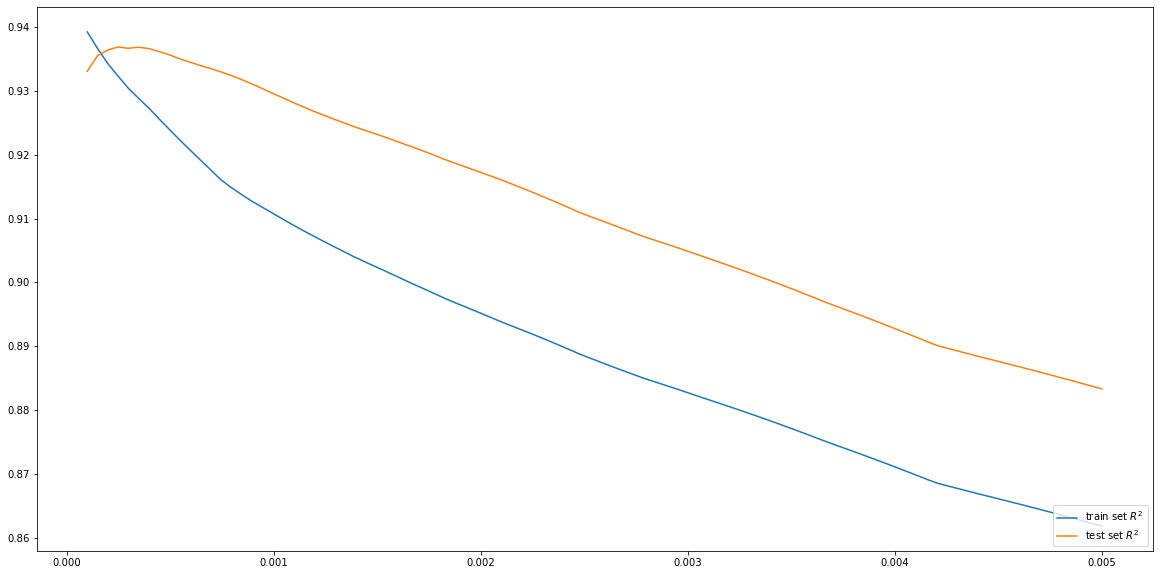

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler, StandardScaler
X_train, X_test, y_train, y_test = train_test_split(dummy,log_predict,test_size=.33)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
lasso = Lasso()


    
alphas = np.linspace(1e-4,.005,100)
coefs = []
train_R2 = []
test_R2  = []
for i,alpha in enumerate(alphas):
    print(i, end = '\r')
    lasso.set_params(alpha = alpha, max_iter = 50000)
    lasso.fit(X_train_scaled,y_train)
    coefs.append(lasso.coef_)
    train_R2.append(lasso.score(X_train_scaled,y_train))
    test_R2.append(lasso.score(scaler.transform(X_test),y_test))
    
plt.plot(alphas, train_R2, label=r'train set $R^2$')
plt.plot(alphas, test_R2, label=r'test set $R^2$')
plt.legend(loc=4)


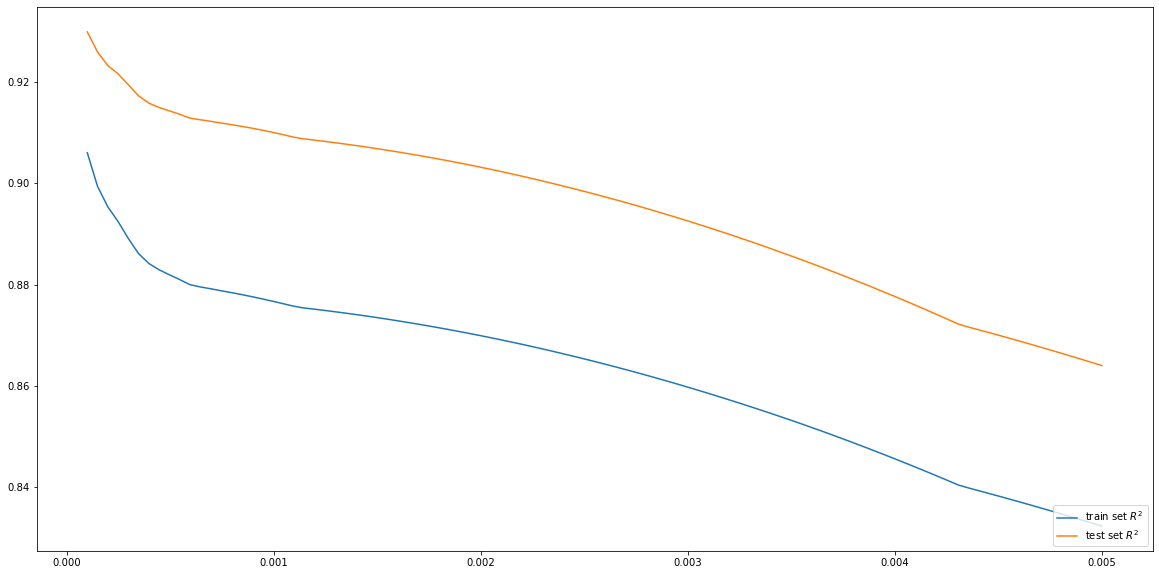

In [23]:
d = pd.get_dummies(data, drop_first=True)
with open("play.txt", "w") as file1:
    coefs = []
    train_R2 = []
    test_R2  = []
    
    alphas = np.linspace(1e-4,.005,100)
    for alpha in alphas:
        lasso.set_params(alpha = alpha, max_iter = 20000)
        lasso.fit(X_train,np.log(y_train))
        coefs.append(lasso.coef_)
        train_R2.append(lasso.score(X_train,np.log(y_train)))
        test_R2.append(lasso.score(X_test,np.log(y_test)))
        print(alpha, end = '\r')

    coefs_data = pd.DataFrame(np.array(coefs),columns = d.columns)
    vals = pd.Series(coefs[50], index = d.columns)
    k_heaviest_weights = vals.abs().sort_values(ascending = False).index[:15]
    plt.rcParams["figure.figsize"] = (20,10)
    for name in k_heaviest_weights:
        plt.plot(alphas, coefs_data[name], label=name)
    plt.legend(loc=1)    
    plt.title(f'Change of Lasso Slopes Varying Alpha for ALL NEIGHBORHOODS , num_observations = {len(d)}')
    plt.savefig(f'neighborhoodLasso/ALL_HOODS.pdf')
    plt.clf()
    
    plt.plot(alphas, train_R2, label=r'train set $R^2$')
    plt.plot(alphas, test_R2, label=r'test set $R^2$')
    plt.legend(loc=4)
    plt.savefig('TEST')

# Training models for each neighborhood to see what features are important to what neighborhood (If any difference even exists)

In [2]:
lasso = Lasso()
scaler = MinMaxScaler()
max_iter = 200000


with open("play2.txt", "w") as file:

    
    for i,neighborhood in enumerate(data.Neighborhood.unique()[:27]):
        print(i, end = '\r')
        indices = data[data.Neighborhood == neighborhood].index
        coefs = []
        alphas = np.linspace(1e-4,.005,250)
        for alpha in alphas:
            lasso.set_params(alpha = alpha, max_iter = max_iter)
            lasso.fit(scaler.fit_transform(dummy.iloc[indices]), log_predict[indices])
            coefs.append(lasso.coef_)
            

        coefs_data = pd.DataFrame(np.array(coefs),columns = d.columns)
        vals = pd.Series(coefs[99], index = d.columns)
        k_heaviest_weights = vals.abs().sort_values(ascending = False).index[:15]
        plt.rcParams["figure.figsize"] = (20,10)
        for name in k_heaviest_weights:
            plt.plot(alphas, coefs_data[name], label=name)
        plt.legend(loc=1)    
        plt.title(f'Change of Lasso Slopes Varying Alpha for {neighborhood} , num_observations = {len(indices)}')
        plt.savefig(f'neighborhoodLasso/{neighborhood}2.pdf')
        plt.clf()
        
        file.writelines(f'********** {neighborhood}  {len(indices)} observations **********\n')
        file.writelines(vals[k_heaviest_weights].to_string())
        file.writelines('\n\n\n\n')
        
    
    coefs = []
    alphas = np.linspace(1e-4,.005,250)
    for alpha in alphas:
        lasso.set_params(alpha = alpha, max_iter = max_iter)
        lasso.fit(scaler.fit_transform(dummy), log_predict)
        coefs.append(lasso.coef_)


    coefs_data = pd.DataFrame(np.array(coefs),columns = d.columns)
    vals = pd.Series(coefs[249], index = d.columns)
    k_heaviest_weights = vals.abs().sort_values(ascending = False).index[:15]
    plt.rcParams["figure.figsize"] = (20,10)
    for name in k_heaviest_weights:
        plt.plot(alphas, coefs_data[name], label=name)
    plt.legend(loc=1)    
    plt.title(f'Change of Lasso Slopes Varying Alpha for whole set , num_observations = {len(dummy)}')
    plt.savefig(f'neighborhoodLasso/ALL_HOODS2.pdf')
    plt.clf()

    file.writelines(f'********** ALL DATA  {len(dummy)} observations **********\n')
    file.writelines(vals[k_heaviest_weights].to_string())
    file.writelines('\n\n\n\n')
        
        

#         plt.plot(alphas, train_R2, label=r'train set $R^2$')
#         plt.plot(alphas, test_R2, label=r'test set $R^2$')
#         plt.legend(loc=4)
#         plt.savefig('TEST')



        
    

NameError: name 'Lasso' is not defined